In [296]:
from scipy.stats import describe, pearsonr, zscore, f_oneway, yeojohnson, shapiro, probplot, levene, boxcox
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')            
#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()   

# Data

In [297]:
df = pd.DataFrame([[1, 1, 4.8],
              [1, 2, 4.1],
              [1, 3, 6.0],
              [1, 4, 6.5],
              [2, 1, 5.8],
              [2, 2, 5.2],
              [2, 3, 6.8],
              [2, 4, 7.4],
              [3, 1, 6.0],
              [3, 2, 5.6],
              [3, 3, 7.5],
              [3, 4, 7.8],
              [4, 1, 6.3],
              [4, 2, 5.9],
              [4, 3, 8.0],              
              [4, 4, 8.4]], columns=["Year", "Trimester", "Sales"])

df["YearQuarter"] = df["Year"].astype(str) + "-Q" + df["Trimester"].astype(str)
df

,Year,Trimester,Sales,YearQuarter
0,1,1,4.8,1-Q1
1,1,2,4.1,1-Q2
2,1,3,6.0,1-Q3
3,1,4,6.5,1-Q4
4,2,1,5.8,2-Q1
5,2,2,5.2,2-Q2
6,2,3,6.8,2-Q3
7,2,4,7.4,2-Q4
8,3,1,6.0,3-Q1
9,3,2,5.6,3-Q2


# Normalización

## Visualization

In [298]:
var = df.copy()

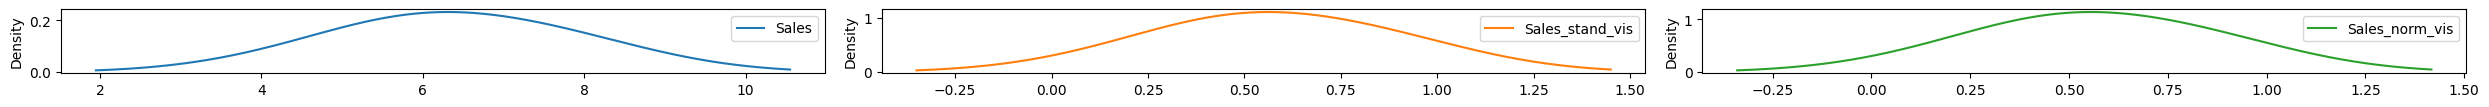

In [299]:
for col in ["Sales"]:
    # Scaling
    scaler = MinMaxScaler(feature_range=(.1, 1))
    var[f"{col}_stand_vis"] = scaler.fit_transform(np.float32(var[[col]]))

    # Normalization
    x_norm, _ = yeojohnson(var[f"{col}_stand_vis"])
    var[f"{col}_norm_vis"] = x_norm  
    
    # Eval Scale & Normalization
    var[[col, f"{col}_stand_vis", f"{col}_norm_vis" ]].plot.kde(bw_method=1, subplots=True, layout=(3,3), sharex=False, figsize=[25,3])
    plt.tight_layout()

## Normalization preprocessing

In [300]:
# normalization of salary cause it wasn't normal
for col in ["Sales"]:
    if "vis" not in col:
        var[col] = var[f"{col}_norm_vis"]
        var.drop(columns=[f"{col}_stand_vis", f"{col}_norm_vis"], inplace=True)     
var.head()

,Year,Trimester,Sales,YearQuarter
0,1,1,0.244902,1-Q1
1,1,2,0.099723,1-Q2
2,1,3,0.491565,1-Q3
3,1,4,0.593617,1-Q4
4,2,1,0.450631,2-Q1


# Sales  distrbution

<AxesSubplot: >

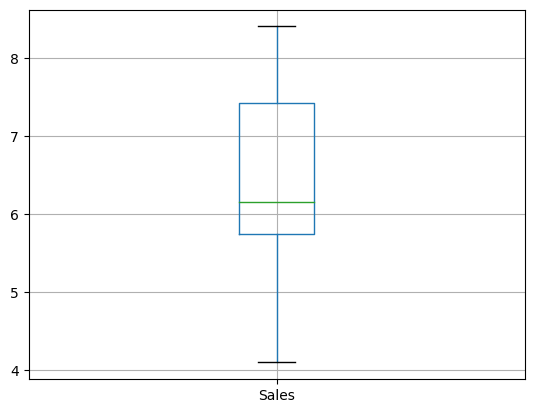

In [301]:
df.boxplot(column=["Sales"])

# Dispersion

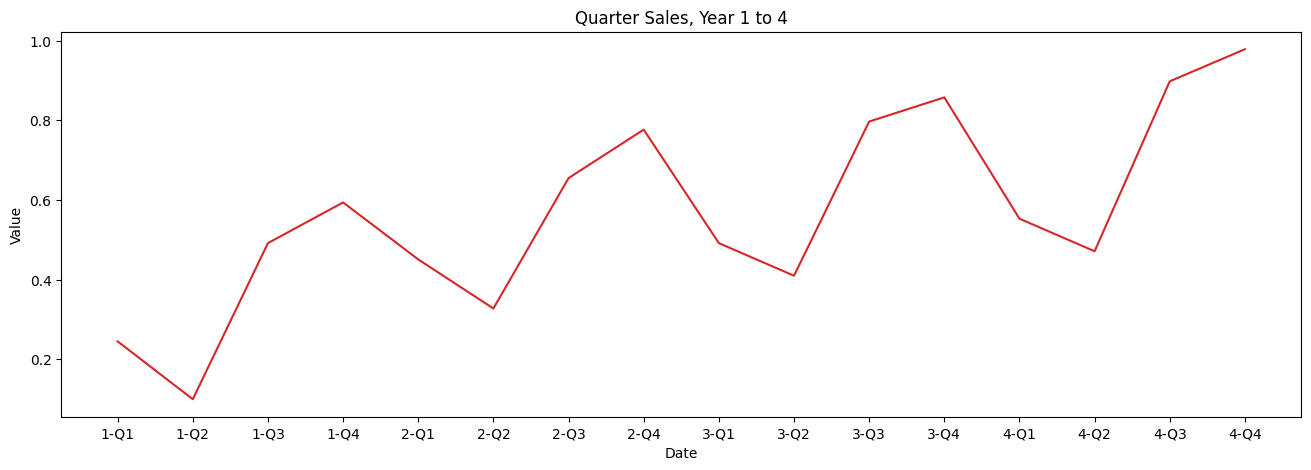

In [302]:
plot_df(var, x=var.YearQuarter, y=var.Sales, title='Quarter Sales, Year 1 to 4')    

Hay una tendencia hacia que incrementen las ventas conforme pasa el tiempo además de un ciclo de subida y bajada de ventas que se cumple año con año empezando en el q2 subiendo hacia el q4 y bajando en el q1 y q2 del siguiente año.

# Trend and Seasonality

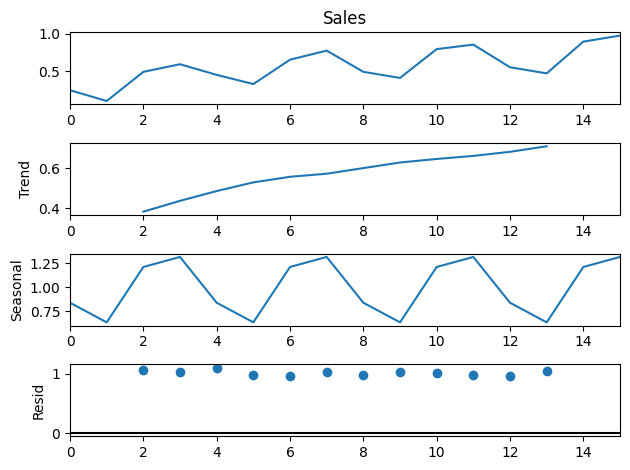

In [303]:
sales_ts = var["Sales"]
r = seasonal_decompose(sales_ts, period=4, model="multiplicative")
plot = r.plot()

Tienen efectivamente tendencia hacia arriba y un ciclo anual

## Índices Estacionales

In [304]:
seasonality=r.seasonal
seasonality[:4]

0    0.838775
1    0.634683
2    1.211025
3    1.315517
Name: seasonal, dtype: float64

## Desestacionalizar

In [305]:
deseason = (var.Sales/seasonality)
deseason.head()

0    0.291976
1    0.157122
2    0.405908
3    0.451242
4    0.537249
dtype: float64

<AxesSubplot: title={'center': 'Ventas desestacionalizadas'}>

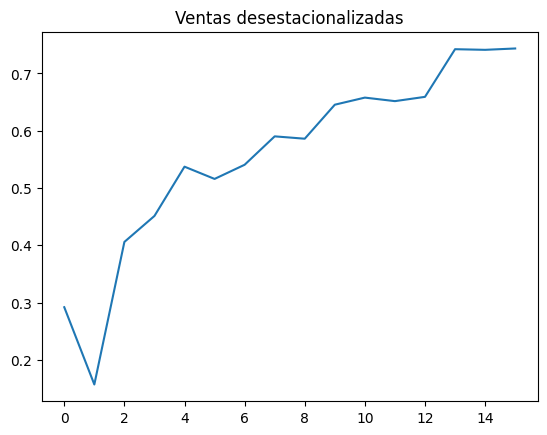

In [306]:
deseason.plot(title="Ventas desestacionalizadas")

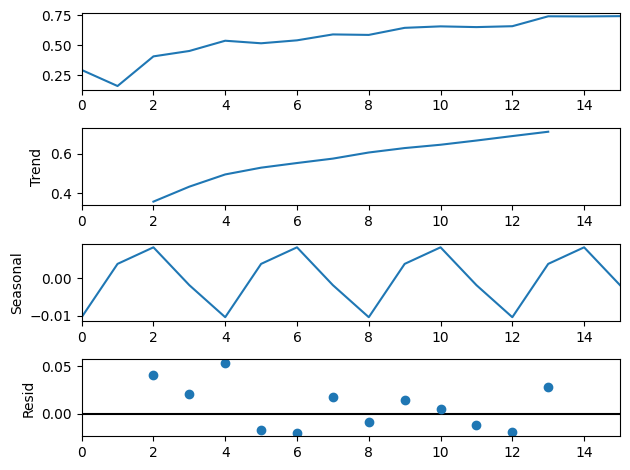

In [307]:
decompose_result = seasonal_decompose(deseason, period = 4)
plot = decompose_result.plot()

## Stationary Test After Deseason

In [308]:
dftest = adfuller(deseason.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5835806800074135
2. P-Value :  0.4918360248124954
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 13
5. Critical Values :
	 1% :  -4.068853732362312
	 5% :  -3.1271488757396453
	 10% :  -2.7017297633136095


# Detrending (Just to Test it)

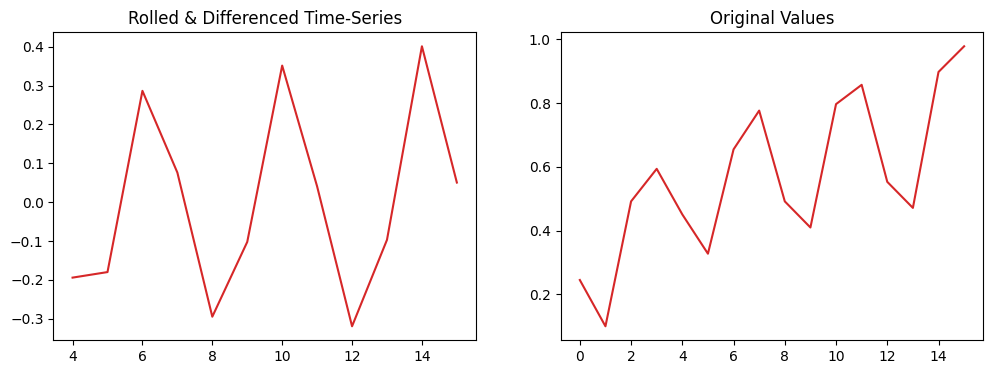

In [309]:
rolling_mean = sales_ts.rolling(window = 4).mean()
sales_rolled_detrended = sales_ts - rolling_mean

sales_rolled_detrended_diff = sales_rolled_detrended - sales_rolled_detrended.shift()

ax1 = plt.subplot(121)
sales_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
sales_ts.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

se le quita la tendencia

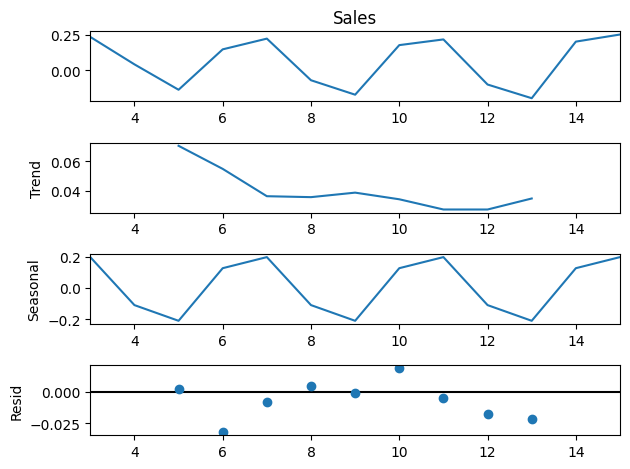

In [310]:
decompose_result = seasonal_decompose(sales_rolled_detrended.dropna(), period = 4)
plot = decompose_result.plot()

## Stationary Test After detrend

In [311]:
dftest = adfuller(sales_rolled_detrended_diff.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.788754465656252
2. P-Value :  2.270635514984248e-14
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 9
5. Critical Values :
	 1% :  -4.473135048010974
	 5% :  -3.28988060356653
	 10% :  -2.7723823456790124


desde que p-vañiue es menor a 0.05 sabemos que la data es estacionaria

# Regresion de ventas desestacionalizadas vs tiempo

In [312]:
var["deseason_sales"]  = deseason

## Modelo

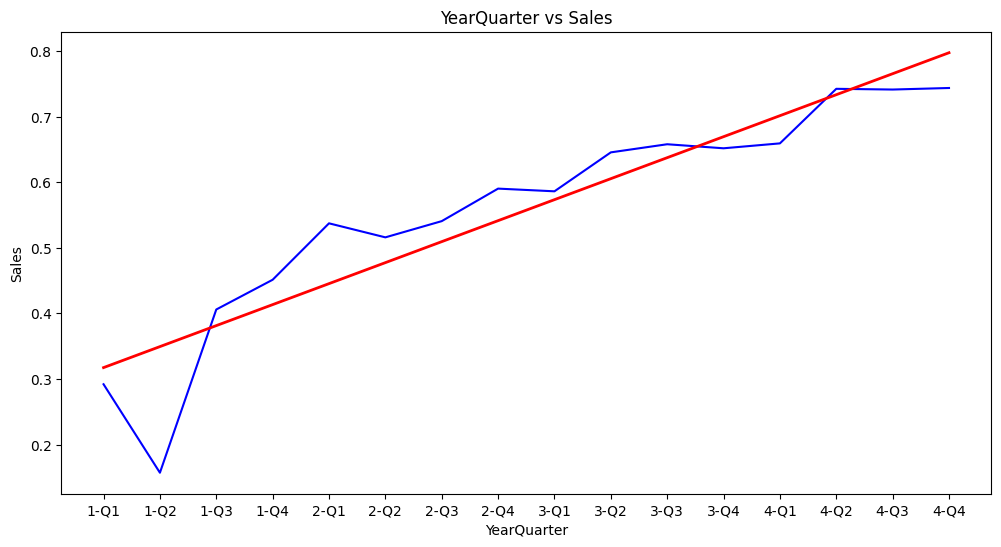

In [314]:
var = var.fillna(0)
var["index"] = var.index

model = smf.ols('deseason_sales ~ index', data=var)
model = model.fit()
sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(var['YearQuarter'], var['deseason_sales'], 'b')           # scatter plot showing actual data
plt.plot(var['YearQuarter'], sales_pred, 'r', linewidth=2) # regression line
plt.xlabel('YearQuarter')
plt.ylabel('Sales')
plt.title('YearQuarter vs Sales')

plt.show()

visualización de las ventas reales vs la línea de tendencia

In [315]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         deseason_sales   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     80.20
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           3.60e-07
Time:                        14:35:00   Log-Likelihood:                 21.884
No. Observations:                  16   AIC:                            -39.77
Df Residuals:                      14   BIC:                            -38.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3173      0.031     10.089      0.0

/home/armando/.virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [326]:
model.rsquared # El modelo explica .85

0.8513722398832965

In [325]:
model.pvalues < .05  # B1 es signficante

Intercept    True
index        True
dtype: bool

tienen un muy buen ajuste el modelo, la variabilidad es bien explicada por el tiempo

In [316]:
from statsmodels.tools.eval_measures import rmse
import numpy as np
test = var[var["deseason_sales"] != 0]
ypred = model.predict(test["index"])

# calc rmse
rmse = rmse(test["deseason_sales"], ypred)

error= test.deseason_sales- ypred

mape = np.round(np.mean(np.abs(100*error/test.deseason_sales )), 0)
print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.06162622364166431
MAPE = 14.0 %


In [317]:
preds = pd.DataFrame([["5Q1", 16],
                      ["5Q2", 17],
                      ["5Q3", 18],
                      ["5Q4", 19]], columns= ["YearQuarter", "index"])
preds

,YearQuarter,index
0,5Q1,16
1,5Q2,17
2,5Q3,18
3,5Q4,19


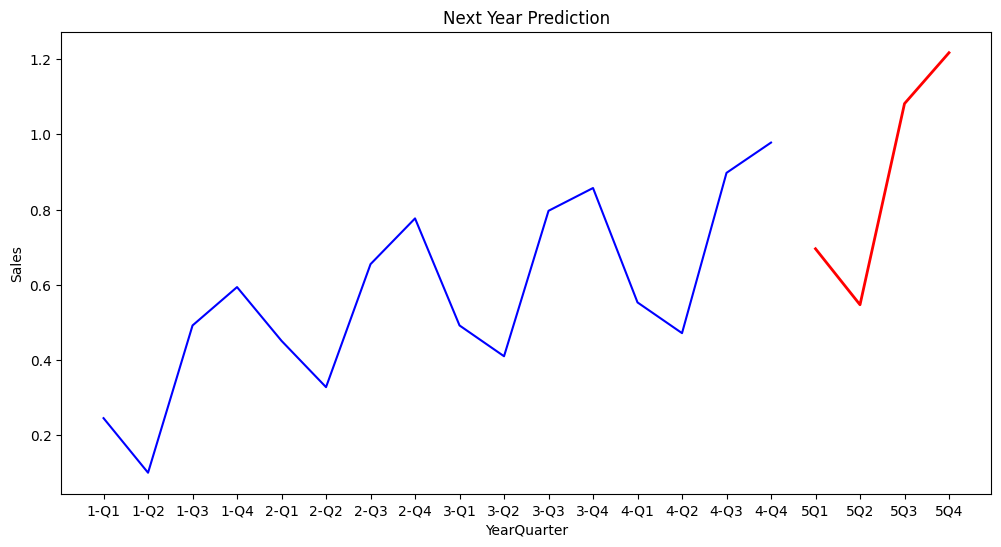

In [318]:
sales_pred = model.predict(preds["index"])

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(var['YearQuarter'], var['Sales'], 'b')           # scatter plot showing actual data
plt.plot(preds["YearQuarter"], sales_pred*seasonality[:4], 'r', linewidth=2) # regression line
plt.xlabel('YearQuarter')
plt.ylabel('Sales')
plt.title('Next Year Prediction')

plt.show()

ventas reales y la predicción del siguiente año

## Normality Test

In [319]:
S, p  = shapiro(model.resid)
print(S, p, "significant" if p<0.05 else "not that significant")

0.8370610475540161 0.008839364163577557 significant


no hay suficiente evidencia para decir que los residuos no vienen de una distribución normal

## Residuals Analysis

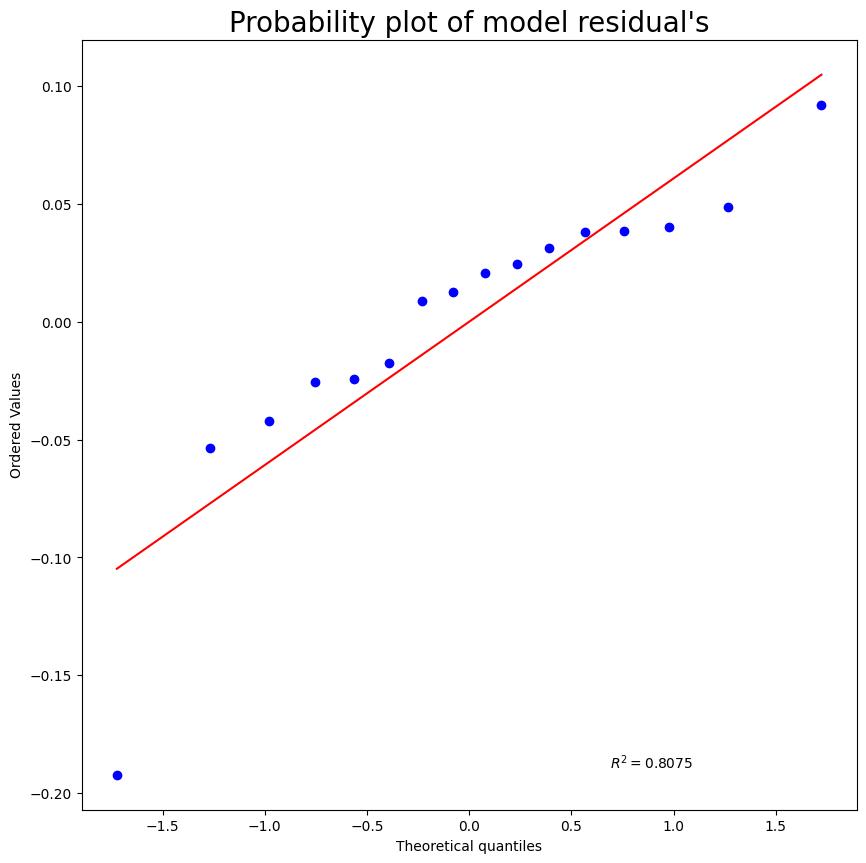

In [320]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

## Assumptions

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


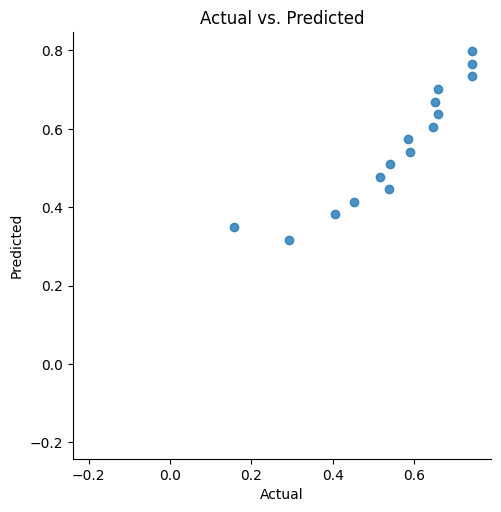

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.019889899436774803
Residuals are not normally distributed


/tmp/ipykernel_781/592797125.py:83: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


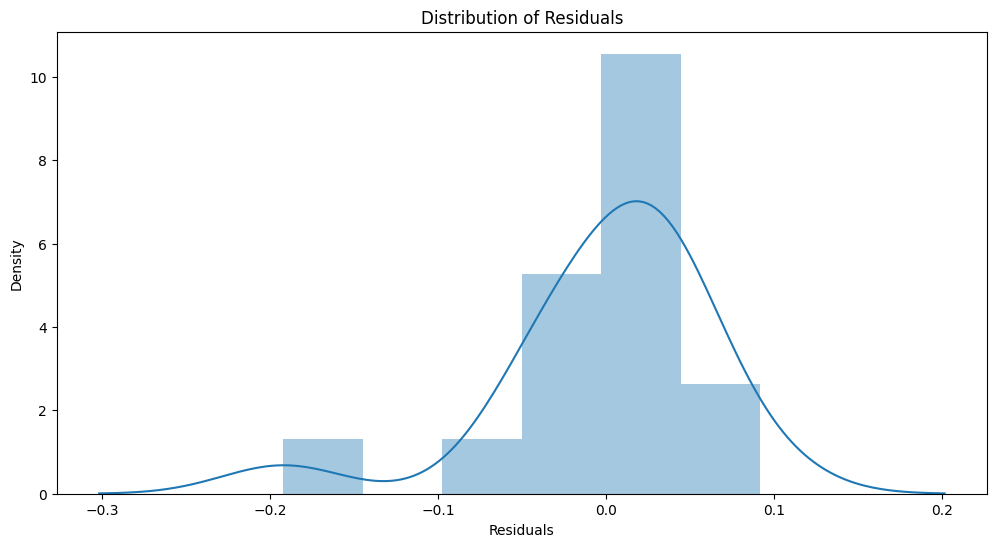


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.4848790259744393
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


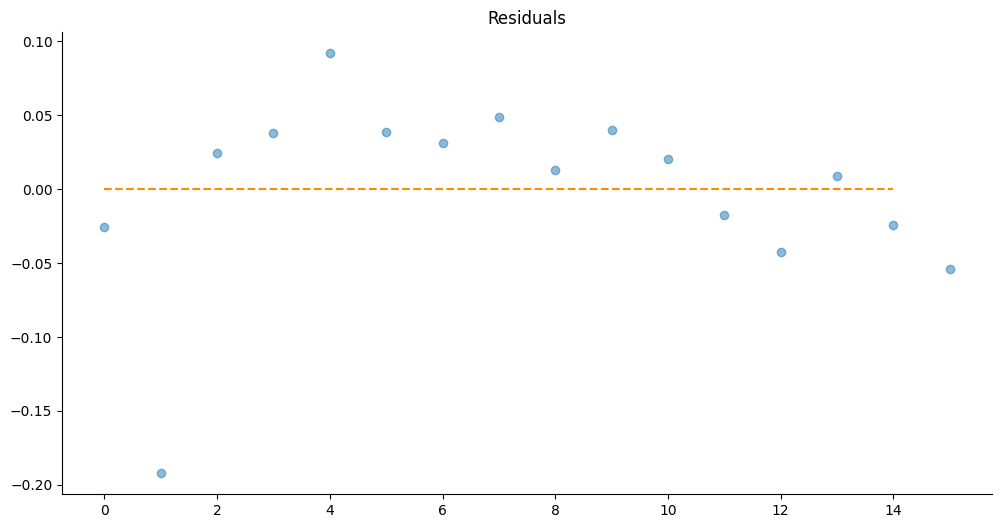

In [321]:
linear_assumption(model, var["index"], var["deseason_sales"])
normal_errors_assumption(model, var["index"], var["deseason_sales"])
#multicollinearity_assumption(model, var["index"], var["deseason_sales"], var["index"])
autocorrelation_assumption(model, var["index"], var["deseason_sales"])
homoscedasticity_assumption(model, var["index"], var["deseason_sales"])

Concluyo que un modelo de regresión linear en este caso no es el más adecuado, se debería considerar un modelo autoregresivo como aRIMA

In [322]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user 
!jupyter nbextension enable codefolding/main
!python -m pip install -U notebook-as-pdf
!pyppeteer-install
!jupyter-nbconvert timeseries.ipynb --no-input --no-prompt --to html

[I 14:35:08 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 14:35:08 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 14:35:08 InstallContribNbextensionsApp] Installing /home/armando/.local/share/virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad -> scratchpad
[I 14:35:08 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/LICENSE
[I 14:35:08 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/README.md
[I 14:35:08 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/scratchpad.yaml
[I 14:35:08 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 14:35:08 InstallContribNbextensionsApp] Up to date: /home/armando/.local/sh